# Neural Networks for Regression
## Introduction to Neural Networks
This part of the introduction summarizes the key theoretical concepts for **Neural Networks for Regression**, building on Chapter 8 of the handbook (pp. 189–199).

In [1]:
#!pip install torch torchsummary

Let us define some basic imports and a `pprint` function.

In [2]:
import numpy as np
import torch
from IPython.display import display, Math
from numpyarray_to_latex.jupyter import to_ltx
import matplotlib.pyplot as plt
plt.style.use(['seaborn-v0_8-muted', 'practicals.mplstyle'])
def pprint(*args):
    res = ""
    for i in args:
        if type(i) == np.ndarray:
            res += to_ltx(i, brackets='[]')
        elif type(i) == torch.Tensor:
            res += to_ltx(i.detach().cpu().numpy(), brackets='[]',)
        elif type(i) == str:
            res += i
    display(Math(res))

### Data Preprocessing for Neural Networks
#### Normalization and Standardization

**Motivation**:
Gradient-based optimization of neural networks often becomes unstable if different features vary widely in scale. Hence, **Sec. 8.1** of the handbook (and earlier practicals) reiterate that scaling inputs to zero mean and unit variance—or to a small bounded range—is essential. This ensures the gradients have more balanced magnitudes across parameters, which helps the optimizer converge more reliably.

**Typical Steps**:
1. Compute the empirical mean and standard deviation of each input dimension:

$$
\mu_j = \frac{1}{N} \sum_{i=1}^N x_{ij}, \quad
\sigma_j = \sqrt{\frac{1}{N}\sum_{i=1}^N (x_{ij}-\mu_j)^2}.
$$

2. Transform (standardise) the data as

$$
x_{ij}^{(std)} = \frac{x_{ij} - \mu_j}{\sigma_j}.
$$

3. Use the same $\mu_j$ and $\sigma_j$ for the validation and test sets to maintain consistency.

#### Input Data Shaping
- **For MLPs**: Usually arrange training data into a matrix of shape $(\text{batch}, n)$, where $n$ is the number of input features.
- **For CNNs**: Reshape data into a 4D tensor of shape $(\text{batch}, \text{channels}, \text{height}, \text{width})$. Convolutional layers exploit the spatial dimensions for images or other grid-like inputs.

```python
import torch

# Suppose X_train is shape (N, n) for an MLP:
N, n = 1000, 10
X_train = torch.randn(N, n)
X_val = torch.randn(N//5, n)
X_test = torch.randn(N//5, n)

mean = X_train.mean(dim=0)
std  = X_train.std(dim=0)

X_train = (X_train - mean) / std
X_val   = (X_val - mean) / std
X_test  = (X_test - mean) / std

# For CNN input, if needed:
H, W = 28, 28  # e.g., image dimension
# Reshape to (N, 1, H, W) for single-channel images:
X_train_cnn = X_train.view(N, 1, H, W)
X_val_cnn   = X_val.view(N//5, 1, H, W)
X_test_cnn  = X_test.view(N//5, 1, H, W)
```

### Feed-Forward Neural Networks (MLPs)

#### Architecture and Notation

An MLP (multi-layer perceptron, or feed-forward network) with $L$ layers (including hidden and output layers) maps an input vector $\mathbf{x}\in\mathbb{R}^n$ to an output (for regression, typically $\hat{y}\in\mathbb{R}$ or $\mathbb{R}^m$) through successive affine transformations and nonlinear activations. In the notation of **Eqs. $(8.1.2)$–$(8.1.5)$**:

1. **Layer 1**:

$$
A^{(1)} = Z^{(0)} W^{(1)} + b^{(1)},\quad Z^{(1)} = g^{(1)}(A^{(1)}),
$$
where $Z^{(0)} = \mathbf{x}$ is the input and $W^{(1)}$ is an $(n \times h_1)$ weight matrix if the first hidden layer has $h_1$ units.

2. **Layer 2** (or subsequent hidden layers):

$$
A^{(2)} = Z^{(1)} W^{(2)} + b^{(2)},\quad Z^{(2)} = g^{(2)}(A^{(2)}),
$$
continuing similarly up to layer $L-1$.

3. **Output Layer** ($l=L$):
For regression with a linear output,

$$
A^{(L)} = Z^{(L-1)} W^{(L)} + b^{(L)},\quad Z^{(L)} = A^{(L)}.
$$

If the output dimension is 1, $W^{(L)}$ is $(h_{L-1} \times 1)$. For vector outputs, adjust accordingly.

#### Activation Functions

Nonlinearities $g^{(l)}(\cdot)$ are critical. Common examples in the course:
- **Sigmoid**: $\sigma(z)=1/(1+e^{-z})$, which saturates for large $|z|$.
- **Tanh**: $\tanh(z)\in(-1,1)$, similar saturation behavior.
- **ReLU**: $\max(0,z)$, which alleviates vanishing gradients on the positive side and is widely used in deep networks.

Without a nonlinear $g^{(l)}$, the stacked linear transformations collapse to an effective single linear mapping. Nonlinearity ensures the network can approximate complex functions (Universal Approximation property).

### Cost function and matrix-based Back-Propagation

#### Sum of Squared Errors (SSE)

For regression tasks, the *empirical sum of squared errors*:

$$
\mathrm{SSE}_{\mathrm{emp}}(\alpha_N) = \sum_{i=1}^N (y_i - \hat{y}(x_i))^2,
$$

where $\hat{y}(x_i)$ is the network’s prediction for input $x_i$, and $y_i$ is the true target. The parameter vector $\alpha_N$ includes $\{W^{(l)}, b^{(l)}\}$ for $l=1,\ldots,L$.

#### Gradient Descent Update

Using the notation from **Algorithm 2 (p. 194)**, we iteratively update each parameter in the direction that reduces the SSE cost:

$$
\alpha_N(k+1) = \alpha_N(k) - \eta\, \frac{\partial\,\mathrm{SSE}_{\mathrm{emp}}}{\partial\,\alpha_N}(k),
$$

where $\eta$ is the learning rate.

#### Back-Propagation (Algorithm 2)

Back-propagation is the application of the chain rule to compute $\nabla \mathrm{SSE}_{\mathrm{emp}}$ with respect to each weight matrix $W^{(l)}$ and bias $b^{(l)}$.

1. **Output-Layer Delta**:

$$
\delta^{(L)} = \frac{\partial\,\mathrm{SSE}_{\mathrm{emp}}}{\partial\,A^{(L)}} \odot g'^{(L)}(A^{(L)}).
$$

- In linear output regression, $g'^{(L)}(\cdot) = 1$, and the cost derivative is $\delta^{(L)} = (\hat{y}-y).$

2. **Backward Recursion**:

$$
\delta^{(l)} = \bigl(W^{(l+1)} \delta^{(l+1)}\bigr) \odot g'^{(l)}(A^{(l)}), \quad l = L-1,\ldots,1.
$$

This “error” $\delta^{(l)}$ is used to compute partial derivatives for $W^{(l)}$ and $b^{(l)}$.

3. **Gradient w.r.t. the weights**:

$$
\frac{\partial\,\mathrm{SSE}_{\mathrm{emp}}}{\partial\,W^{(l)}} = (Z^{(l-1)})^\top \,\delta^{(l)},\quad
\frac{\partial\,\mathrm{SSE}_{\mathrm{emp}}}{\partial\,b^{(l)}} = \sum_{i=1}^{N} \delta^{(l)}_i.
$$

using the matrix-based form.

In [3]:
import torch.nn as nn

class Simple2LayerMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)  # ReLU activation
        x = self.fc2(x)    # linear output for regression
        return x

# Instantiate the network and define SSE-like loss
model = Simple2LayerMLP(input_dim=10, hidden_dim=15, output_dim=1)
criterion = nn.MSELoss(reduction='sum')  # SSE (sum of squared errors)
eta = 1e-2

# Dummy data
X_sample = torch.randn(5, 10)
y_sample = torch.randn(5, 1)

y_pred = model(X_sample)
loss = criterion(y_pred, y_sample)

# Backpropagate
loss.backward()

# Gradient descent step
with torch.no_grad():
    for param in model.parameters():
        param -= eta * param.grad
        param.grad.zero_()

### Convolutional Neural Networks (CNNs)

Though the practical focuses on regression, CNNs (p. 198–199) illustrate deep architectures that handle grid-structured data (e.g., images). Main ideas:
1. **Local Connectivity**: Each neuron in a convolutional layer only connects to a local patch of the input.
2. **Shared Weights**: A small kernel (filter) is “convolved” across the entire image or feature map.
3. **Translation Equivariance**: The same filter is applied at all spatial locations.

#### Convolution Operation
A single 2D filter:

$$
y_{ij} = \sum_{m=1}^{k_h} \sum_{n=1}^{k_w} W_{mn} x_{(i + m - 1, j + n - 1)} + b,
$$

where $(k_h, k_w)$ is the kernel size. ReLU or another activation is then applied.

#### Pooling Layers
Often, a **pooling** layer follows one or more convolutional layers to reduce the spatial resolution. For instance, **max pooling** with a $2\times2$ window and stride 2 halves the height and width.

### Overfitting and Cross-Validation

#### Overfitting Phenomenon

In the handbook’s example on **p. 197**, a network with 15 hidden units achieves extremely low training SSE but high test SSE, illustrating **overfitting**. Overfitting arises when a model fits training data “too well,” capturing noise rather than the underlying trend.

#### Detection and Mitigation
- **Validation Set**: Split data into training and validation. Monitor the validation error (e.g., MSE). If it increases while training error decreases, the model is overfitting.
- **Cross-Validation**: Alternatively, use $k$-fold cross-validation.
- **Regularization**:
  - **Dropout**: Temporarily “drop” a fraction of hidden units during training.
  - **Weight Decay (L2)**: Penalizes large weights.
  - **Early Stopping**: Halt training when validation performance stops improving.

### Practical Aspects: Model Saving and Loading in PyTorch

For safe and reproducible experiments, one typically needs to **save**:
1. **Model Weights (state_dict)**: The learned parameters $\{W^{(l)},b^{(l)}\}$.
2. **Optimizer State (if resuming)**: Internal states like momentum buffers in gradient-based optimizers.

A typical code pattern:

In [4]:
import torch.optim as optim

model = Simple2LayerMLP(10, 15, 1)
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training... then save checkpoint
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': 10
}, "checkpoint.pth")

# Later, to resume
checkpoint = torch.load("checkpoint.pth", weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1

# For inference, only model_state_dict is strictly required.

### Complete example of a CNN for Regression
Below is a more detailed illustration of an implementation of a CNN in PyTorch for regression highlighting many of the points presented above:

In [5]:
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

# This CNN will perform a regression task (e.g., predicting a real-valued output from an image).
# We'll use two convolution layers (with 2x2 max pooling after each), then two fully-connected layers,
# include dropout with probability=0.25, and weight decay in the optimizer for regularization.

class SimpleCNNRegression(nn.Module):
    def __init__(self):
        super().__init__()
        
        # First convolution
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
        
        # Second convolution
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        
        # After two 2x2 pools on a 28x28 input, the spatial dimension goes 28->14->7
        # => final feature map is 16 x 7 x 7 = 16*7*7 = 784
        self.fc1   = nn.Linear(16 * 7 * 7, 64)  
        self.fc2   = nn.Linear(64, 1)          # single output for regression
        
        # Dropout layer to help regularize the fully connected part
        self.dropout = nn.Dropout(p=0.25)
        
        # MaxPool layer (2x2) used after each convolution
        self.pool   = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # First conv: conv1 -> ReLU -> pool => shape: (N, 8, 14, 14)
        x = self.conv1(x)        
        x = F.relu(x)
        x = self.pool(x)
        
        # Second conv: conv2 -> ReLU -> pool => shape: (N, 16, 7, 7)
        x = self.conv2(x)        
        x = F.relu(x)
        x = self.pool(x)
        
        # Flatten => shape: (N, 16*7*7 = 784)
        x = x.view(x.size(0), -1)
        
        # First fully connected => ReLU => Dropout => shape: (N, 64)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # Final fully connected => shape: (N, 1)
        x = self.fc2(x)
        return x

# We'll create some dummy data for regression:
# - Shape of X: (N, 1, 28, 28)
# - Shape of y: (N, 1) containing continuous values
N_train = 1000
N_val   = 200
X_train = torch.randn(N_train, 1, 28, 28)
y_train = torch.randn(N_train, 1)  # random continuous targets
X_val   = torch.randn(N_val, 1, 28, 28)
y_val   = torch.randn(N_val, 1)

# We'll wrap the data in TensorDatasets and DataLoaders for batching
train_dataset = TensorDataset(X_train, y_train)
val_dataset   = TensorDataset(X_val, y_val)
batch_size    = 50
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader    = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

# Instantiate our CNN model
model = SimpleCNNRegression()

# We'll use MSELoss for this regression task
criterion = nn.MSELoss()

# We'll use Adam optimizer with weight decay for L2 regularization
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Setup for training with early stopping
max_epochs         = 20
patience           = 3  # number of epochs with no improvement allowed
best_val_loss      = float('inf')
epochs_no_improve  = 0
best_model_path    = "best_model.pth"

for epoch in range(max_epochs):
    # Train mode: enables dropout, etc.
    model.train()
    running_train_loss = 0.0
    
    # Fetch mini-batches from the training loader
    for X_batch, y_batch in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass -> compute predictions
        preds = model(X_batch)
        
        # Compute MSE loss for regression
        loss = criterion(preds, y_batch)
        
        # Backward pass -> compute gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        running_train_loss += loss.item()
    
    # Compute average training loss for this epoch
    avg_train_loss = running_train_loss / len(train_loader)
    
    # Validation phase (disable dropout, etc.)
    model.eval()
    running_val_loss = 0.0
    
    with torch.no_grad():
        for Xv_batch, yv_batch in val_loader:
            # Forward pass on validation set
            val_preds = model(Xv_batch)
            val_loss = criterion(val_preds, yv_batch)
            running_val_loss += val_loss.item()
    
    avg_val_loss = running_val_loss / len(val_loader)
    
    print(f"Epoch [{epoch+1}/{max_epochs}]  "
          f"Train MSE: {avg_train_loss:.4f}  "
          f"Val MSE: {avg_val_loss:.4f}")
    
    # Early stopping check
    if avg_val_loss < best_val_loss:
        # If validation improves, update best_val_loss and reset patience counter
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # Save current model as best
        torch.save(model.state_dict(), best_model_path)
        print("  Best model saved (improved validation MSE).")
    else:
        epochs_no_improve += 1
        # If no improvement for 'patience' epochs, stop
        if epochs_no_improve >= patience:
            print("Early stopping triggered (no improvement).")
            break

print("\nTraining complete. Loading best model for final checks.")
best_model = SimpleCNNRegression()
best_model.load_state_dict(torch.load(best_model_path, weights_only=False))
best_model.eval()

# We can now evaluate 'best_model' on the validation set (or test set if we had one).
# For instance, a quick check of final validation MSE:
final_val_loss = 0.0
with torch.no_grad():
    for Xv_batch, yv_batch in val_loader:
        val_preds = best_model(Xv_batch)
        val_loss = criterion(val_preds, yv_batch)
        final_val_loss += val_loss.item()
print(f"Final validation MSE (best model): {final_val_loss / len(val_loader):.4f}")

Epoch [1/20]  Train MSE: 1.0996  Val MSE: 1.0189
  Best model saved (improved validation MSE).


Epoch [2/20]  Train MSE: 1.0644  Val MSE: 1.0106
  Best model saved (improved validation MSE).


Epoch [3/20]  Train MSE: 1.0591  Val MSE: 1.0120


Epoch [4/20]  Train MSE: 1.0500  Val MSE: 1.0209


Epoch [5/20]  Train MSE: 1.0298  Val MSE: 0.9982
  Best model saved (improved validation MSE).


Epoch [6/20]  Train MSE: 1.0053  Val MSE: 0.9998


Epoch [7/20]  Train MSE: 0.9564  Val MSE: 0.9923
  Best model saved (improved validation MSE).


Epoch [8/20]  Train MSE: 0.9213  Val MSE: 1.0034


Epoch [9/20]  Train MSE: 0.8346  Val MSE: 1.0201


Epoch [10/20]  Train MSE: 0.7552  Val MSE: 1.0339
Early stopping triggered (no improvement).

Training complete. Loading best model for final checks.
Final validation MSE (best model): 0.9923


## Introduction to PyTorch tensors

PyTorch is a popular open-source deep learning framework, and **tensors** are its core data structure. In PyTorch, tensors are the central data abstraction – a specialized data structure very similar to arrays or matrices, used to represent data (inputs, outputs, model parameters) in deep learning models. Tensors are conceptually like NumPy’s multi-dimensional arrays, but with two key advantages: they can run on GPUs (for accelerated computing), and they support automatic differentiation (through PyTorch’s autograd engine) for computing gradients. These features make tensors fundamental for building and training neural networks.

In this introduction, we’ll explore PyTorch tensors from the ground up. We assume you are comfortable with Python and NumPy, but completely new to PyTorch. We’ll cover what tensors are and how they compare to NumPy arrays, how to create and manipulate them, basic operations, how PyTorch’s autograd works for automatic differentiation, and some additional important tensor functionalities like broadcasting, using GPUs, and in-place operations. Along the way, you’ll find hands-on code examples you can run and modify to solidify your understanding.

Let's get started by importing PyTorch (the `torch` library) and seeing how to create tensors in various ways.

PyTorch (`torch`) provides the `Tensor` class, which, as mentioned, is similar to NumPy’s `ndarray`s but with GPU support and gradient computation. If you’re familiar with NumPy arrays, you’ll find the tensor API quite intuitive. In fact, many operations (creation, indexing, math, etc.) have a very similar syntax.

One important difference is that PyTorch operations can be automatically differentiated (if required), which is essential for tasks like training neural networks.

### Creating Tensors

There are many ways to create a tensor in PyTorch. Here are some of the most common methods:

1. **From Python data**: You can create a tensor directly from a Python list or sequence of numbers using `torch.tensor()`. PyTorch will automatically infer the data type (dtype) if not specified.
2. **From a NumPy array**: PyTorch can convert NumPy `ndarray`s into tensors with `torch.from_numpy()`, and vice versa using the Tensor’s `.numpy()` method. This makes it easy to move data between NumPy and PyTorch. (Notably, if the NumPy array is on CPU, the tensor and the array will share the same memory buffer, so changing one will also change the other.)
3. **Using factory functions**: PyTorch provides factory methods to create tensors with specific values or distributions. For example, `torch.zeros(shape)` creates a tensor filled with zeros, `torch.ones(shape)` creates one filled with ones, and `torch.rand(shape)` creates one with random values uniformly sampled between 0 and 1. You can also create tensors based on an existing tensor’s properties with functions like `torch.ones_like(existing_tensor)` or `torch.rand_like(existing_tensor)`.
4. **Uninitialized tensors**: If you need an uninitialized tensor (just allocating memory without setting values), you can use `torch.empty(shape)`.
5. **Specifying data types and devices**: All the above functions accept a `dtype` parameter to specify the tensor’s data type (e.g. `torch.float32`, `torch.int64`, etc.), and a `device` parameter to specify whether the tensor should reside on the CPU or GPU. By default, PyTorch tensors are created with `dtype=torch.float32` (for floating point numbers) and on the CPU.

Let’s go through some examples of creating tensors.

In [6]:
# Creating a tensor from a Python list
data_list = [[1, 2, 3], [4, 5, 6]]
x_data = torch.tensor(data_list)
pprint("\\text{Tensor from list:}", x_data)

# Creating a tensor from a NumPy array
np_array = np.array(data_list)
x_np = torch.from_numpy(np_array)
pprint("\\text{Tensor from NumPy array:}", x_np)

# Verify that modifying the NumPy array changes the tensor (shared memory)
np_array[0, 0] = 99
pprint("\\text{After modifying the NumPy array, the Tensor becomes:}", x_np)

# Creating tensors using factory functions
shape = (2, 3)
x_zeros = torch.zeros(shape)
x_ones = torch.ones(shape)
x_rand = torch.rand(shape)
pprint("\\text{Zero Tensor:}", x_zeros)
pprint("\\text{Ones Tensor:}", x_ones)
pprint("\\text{Random Tensor:}", x_rand)

# Creating tensors based on existing ones
x_like = torch.ones_like(x_rand)        # tensor of ones with same shape as x_rand
x_like_float = torch.rand_like(x_data, dtype=torch.float32)  # random tensor with same shape as x_data, but forced float type
pprint("\\text{Ones-like Tensor:}", x_like)
pprint("\\text{Rand-like Tensor with float32 dtype:}", x_like_float)

# Checking tensor attributes
print("Tensor shape:", x_data.shape)
print("Tensor data type:", x_data.dtype)
print("Tensor device:", x_data.device)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Tensor shape: torch.Size([2, 3])
Tensor data type: torch.int64
Tensor device: cpu


### Basic Tensor Operations
Once you have tensors, PyTorch provides a rich set of operations to manipulate them. In fact, there are over 100 tensor operations available, including arithmetic, linear algebra, slicing, reshaping, and more. Many of these mirror NumPy operations in syntax and function. Let’s go through some fundamental operations.

#### Arithmetic operations
Arithmetic on tensors is typically element-wise (just like with NumPy arrays). You can use Python arithmetic operators (`+`, `-`, `*`, `/`) or the equivalent `torch` functions (`torch.add`, `torch.sub`, etc.). For example:

In [7]:
# Element-wise arithmetic operations
a = torch.tensor([1.0, 2.0, 3.0])
b = torch.tensor([4.0, 5.0, 6.0])

pprint("a=", a)
pprint("b=", b)
pprint("a + b =", a + b)        # element-wise addition
pprint("a \\times b =", a * b)        # element-wise multiplication
pprint("a - b =", a - b)        # element-wise subtraction
pprint("\\frac{a}{b} =", a / b)        # element-wise division

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

The results should be as expected:

- `a + b` gives `[5.0, 7.0, 9.0]`
- `a * b` gives `[4.0, 10.0, 18.0]`
- etc.

If you want to do **matrix multiplication** (dot products, etc.), you should use the `@` operator or `torch.matmul`. For example, `A @ B` does matrix multiply if `A` and `B` are 2-D matrices (or higher-dim, following broadcast batch rules). For 1-D vectors, `a @ b` will give a scalar dot product. Let’s see a quick example:

In [8]:
# Matrix multiplication vs elementwise
A = torch.tensor([[1, 2],
                  [3, 4]])
B = torch.tensor([[5, 6],
                  [7, 8]])
pprint("A=", A)
pprint("B=", B)
pprint("\\text{Element-wise multiply:}", A * B)   # same shape -> elementwise product
pprint("\\text{Matrix multiply:}", A @ B)         # 2x2 @ 2x2 -> 2x2 matrix result

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Here, `A * B` will do element-wise multiplication (resulting in $\begin{bmatrix}5&12\\21&32\end{bmatrix}$), whereas `A @ B` will compute the matrix product (result $\begin{bmatrix}19&22\\43&50\end{bmatrix}$).

#### Indexing and slicing

You can access and modify parts of tensors using indexing and slicing, just like with NumPy. PyTorch uses 0-based indexing. You can use indices, ranges, colons, and even Boolean masks or index tensors (though advanced indexing is outside our scope here). Some examples:

In [9]:
# Create a 2-D tensor (matrix) for demonstration
x = torch.tensor([[10, 11, 12],
                  [20, 21, 22],
                  [30, 31, 32]])
pprint("\\text{Original tensor: }", x)

# Indexing a single element
pprint("\\text{Element at (0, 1): }", str(x[0, 1].item()))   # .item() to get Python scalar

# Slicing rows and columns
pprint("\\text{First row: }", x[0])            # equivalent to x[0, :]
pprint("\\text{Last column: }", x[:, -1])       # all rows, last column

# Slice a submatrix (e.g., top-left 2x2 block)
sub_x = x[0:2, 0:2]   # rows 0-1 and cols 0-1
pprint("\\text{Top-left 2x2 sub-tensor: }", sub_x)

# Modify part of the tensor
x[1:, 1:] = torch.tensor([[ -1, -2],
                          [ -3, -4]])   # set bottom-right 2x2 block to new values
pprint("\\text{Tensor after modification: }", x)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [10]:
# Reshape (view) a tensor
t = torch.arange(16)        # 1-D tensor [0, 1, 2, ..., 15]
pprint("t=", t)

t_matrix = t.reshape(4, 4)  # reshape to 4x4 matrix
pprint("\\text{t reshaped to 4x4: }", t_matrix)

# Transpose the matrix (swap dimensions)
pprint("t^T:\ ", t_matrix.T)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [11]:
# Concatenate two tensors
t1 = torch.tensor([[1, 2, 3],
                   [4, 5, 6]])
t2 = torch.tensor([[7, 8, 9],
                   [10, 11, 12]])
t_cat0 = torch.cat([t1, t2], dim=0)  # concatenate along rows (dim=0)
t_cat1 = torch.cat([t1, t2], dim=1)  # concatenate along columns (dim=1)

pprint("t_1=", t1)
pprint("t_2:=", t2)
pprint("t_1\\text{ and }t_2\\text{  concatenated along dim=0: }", t_cat0)
pprint("t_1\\text{  and }t_2\\text{  concatenated along dim=1: }", t_cat1)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Here:

- We created a 1-D tensor `t` with 16 sequential elements. We reshaped it into a 4×4 tensor `t_matrix`.
- We transposed `t_matrix` with `.T`.
- We took two 2×3 tensors `t1` and `t2` and concatenated them. Along `dim=0` (rows), we got a 4×3 tensor by stacking `t2` below `t1`. Along `dim=1` (columns), we got a 2×6 tensor by stacking `t2` to the right of `t1`.

These basic operations (arithmetic, indexing, reshaping, concatenation, etc.) allow you to manipulate tensor data in flexible ways. PyTorch’s API is designed to be highly compatible with NumPy’s where it makes sense.


### Autograd and Gradients
One of the most powerful features of PyTorch is its **autograd** system, which allows automatic computation of gradients for tensor operations. This is what enables training of neural networks using gradient descent: you define a forward computation, and PyTorch can compute the backward gradients for you.

In PyTorch, the `torch.autograd` engine tracks all operations on tensors that have `requires_grad=True`. By default, tensors do **not** track gradients. You need to specify which tensors require gradient computation (usually the learnable parameters of your model, or any input for which you want to compute a derivative) by setting `requires_grad=True` when creating the tensor or by calling `.requires_grad_()` on an existing tensor.

When you perform operations on such tensors, PyTorch builds a computational graph behind the scenes: nodes are tensors, and edges are functions that produce output tensors from input tensors. Once you have a result (typically a scalar loss value), you can call `.backward()` on it, and PyTorch will automatically traverse the graph to compute the gradient of that result with respect to every tensor that has `requires_grad=True` (using the chain rule of calculus). Let’s see a simple example to illustrate this:

In [12]:
# A simple autograd example: y = f(x) where f(x) = x^2 + 2x + 1
x = torch.tensor(3.0, requires_grad=True)   # define a tensor x with gradient tracking
print("x:", x)

# Define a function of x
y = x**2 + 2*x + 1
print("y:", y)

# Compute the gradient dy/dx by calling backward on y
y.backward()    # computes gradient of y w.r.t. x
print("dy/dx at x=3:", x.grad)

x: tensor(3., requires_grad=True)
y: tensor(16., grad_fn=<AddBackward0>)
dy/dx at x=3: tensor(8.)


In this example:

- We created a tensor `x` with value `3.0` and `requires_grad=True`. This means PyTorch will track operations on `x`.
- We computed `y = x**2 + 2*x + 1`. Because `x` requires grad, `y` will also by default require grad and have a grad function associated.
- We called `y.backward()`. Since `y` is a scalar (single value), we can call `backward` directly. After this call, the gradient of `y` with respect to `x` is computed and stored in `x.grad`.
- We printed `x.grad`. The derivative $ y = x^2 + 2x + 1 $ is $ dy/dx = 2x + 2 $. At $ x = 3 $, that is `8`.

**Important notes about autograd**:

1. You can disable gradient tracking by wrapping code in `with torch.no_grad():` or by using `.detach()` on a tensor to get a new tensor that shares the same data but with no grad tracking.
2. If `y` is not a scalar, you need to specify a gradient argument in `y.backward(gradient=...)` which is the tensor of same shape as `y` containing the gradient of the final result w.r.t. each element of `y`.
3. By default, gradients are **accumulated** into the `.grad` property. So typically you want to zero out gradients (e.g., `x.grad.zero_()`) between independent backward passes.

Autograd is what powers training routines. If you had a multi-parameter function (like a neural network with many weights), you would set `requires_grad=True` for all those parameters. After computing a loss (scalar), you’d call `loss.backward()`, and each parameter tensor’s `.grad` will be filled with its gradient.

To reinforce understanding, let’s do a slightly more complex autograd example with two inputs:

In [13]:
# Autograd with two inputs: z = x * y + y^2
x = torch.tensor(2.0, requires_grad=True)
y = torch.tensor(-3.0, requires_grad=True)

z = x * y + y**2   # z is a function of both x and y
print("z:", z)

z.backward()  # Compute gradients dz/dx and dz/dy
print("dz/dx:", x.grad)   # should be y
print("dz/dy:", y.grad)   # should be x + 2y

z: tensor(3., grad_fn=<AddBackward0>)
dz/dx: tensor(-3.)
dz/dy: tensor(-4.)


Here $ z = x \times y + y^2 $. We expect $ dz/dx = y $ and $ dz/dy = x + 2y $. With $ x = 2.0 $ and $ y = -3.0 $, those values are $ dz/dx = -3 $ and $ dz/dy = 2 + 2(-3) = -4 $. The autograd should produce the same results in `x.grad` and `y.grad`.

### Advanced Tensor Functions

#### Broadcasting

Like NumPy, PyTorch supports **broadcasting** – a mechanism that allows arithmetic operations on tensors of different shapes by automatically expanding one of them to match the shape of the other. Broadcasting rules in PyTorch are the same as NumPy’s. In short, two tensors are compatible for an elementwise operation if their shapes are equal or align in such a way that one of them can be expanded (a dimension of size 1 can be expanded to match the other’s size, and missing dimensions are treated as size 1).

For example, if you have a tensor of shape (4, 3) and another of shape (3,), you can add them because the second tensor can be treated as if it were (1, 3) and then expanded to (4, 3) to match the first tensor’s shape.

In code, we can demonstrate broadcasting with a simple example:

In [14]:
# Broadcasting example: add a vector to each row of a matrix
mat = torch.tensor([[0, 0, 0],
                    [10, 10, 10],
                    [20, 20, 20],
                    [30, 30, 30]])   # shape (4,3)
vec = torch.tensor([1, 2, 3])        # shape (3,)

result = mat + vec  # vec is broadcast to shape (4,3)
pprint("M=", mat)
pprint("V=", vec)
pprint("M+V", result)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Here, `vec` is added to each row of `mat`. The expected result would be each row of `mat` incremented by `[1, 2, 3]`. Broadcasting is a powerful feature that makes your code more concise and often more efficient.

#### Device Management (CPU vs GPU)

One of PyTorch’s strengths is the ability to perform computations on a **GPU** for speed. Tensors can reside on either the CPU or the GPU. By default, tensors are created on the CPU.
You can check where a tensor is located by looking at its `.device` attribute. To leverage a GPU (if you have one and PyTorch is installed with CUDA support), you need to explicitly move tensors to the GPU. There are a few ways to do this:

1. Using the `.to(device)` method on a tensor, where `device` is something like `torch.device("cuda")` or the shorthand string `"cuda"`.
2. Using `.cuda()` method on the tensor.
3. Creating the tensor directly on the GPU by specifying `device=torch.device("cuda")` (or `device="cuda"`) in the creation function.

It’s common to write code that is device-agnostic (runs on CPU if no GPU is available, otherwise uses the GPU). For example:

In [15]:
# Device-agnostic code: choose CPU or CUDA
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
print("Using device:", device)

# Create a tensor on the chosen device
x = torch.tensor([1.0, 2.0, 3.0], device=device)
print("x device:", x.device)

# Alternatively, move an existing tensor to the device
y = torch.ones(3)            # defaults to CPU
y = y.to(device)             # move to GPU if available
print("y device:", y.device)

Using device: mps
x device: mps:0
y device: mps:0


If you actually run this on a system with a GPU and CUDA installed, you should see device printed as `cuda:0` and the tensor devices as such. On a CPU-only system, it will say `cpu`.

A quick verification of CPU vs GPU performance can be done by timing a large matrix multiplication. (Note: if you actually run this, avoid printing the giant result; just measure the time.)

In [16]:
import time

# Large tensor operation on CPU vs GPU (if available)
large_cpu = torch.randn(10000, 10000)  # 10000x10000 matrix on CPU
start = time.time()
res_cpu = large_cpu @ large_cpu       # matrix multiply on CPU
end = time.time()
print("CPU computation time:", end - start, "seconds")

if torch.cuda.is_available():
    large_gpu = large_cpu.to("cuda")
    torch.cuda.synchronize()  # ensure data is transferred
    start = time.time()
    res_gpu = large_gpu @ large_gpu   # matrix multiply on GPU
    torch.cuda.synchronize()  # wait for GPU to finish computation
    end = time.time()
    print("GPU computation time:", end - start, "seconds")

if torch.backends.mps.is_available():
    large_gpu = large_cpu.to("mps")
    start = time.time()
    res_gpu = large_gpu @ large_gpu
    end = time.time()
    print("MPS computation time:", end - start, "seconds")

CPU computation time: 2.077578067779541 seconds
MPS computation time: 0.055735111236572266 seconds


This snippet will likely show that the GPU computation is significantly faster for large matrix operations (depending on hardware). Remember to move your **model parameters** and **data** to the same device before doing operations.

For example, the code below moves a tensor to GPU if available:


In [17]:
tensor = torch.rand(3)
print("Before moving, device:", tensor.device)
if torch.cuda.is_available():
    tensor = tensor.to('cuda')
    print("After moving, device:", tensor.device)
if torch.backends.mps.is_available():
    tensor = tensor.to('mps')
    print("After moving, device:", tensor.device)

Before moving, device: cpu


After moving, device: mps:0


Running this will print:
```
Before moving, device: cpu
After moving, device: cuda:0
```
if you have a GPU, or
```
Before moving, device: cpu
After moving, device: mps:0
```
on M-chip Apple devices.

In [18]:
torch.set_default_device(device)

#### In-place Operations

PyTorch differentiates between operations that create new tensors and those that modify an existing tensor **in-place**. In-place operations are identified by an underscore suffix in the method name. For example, `tensor.add_(5)` will add 5 to every element of the tensor **in-place** (mutating the tensor), whereas `tensor.add(5)` returns a new tensor with the result and leaves the original unchanged. All functions ending in `_` modify the tensor in-place.

Why use in-place ops? They can save memory and sometimes a bit of compute, because you don’t allocate a new tensor for the result. However, be careful: in-place operations can sometimes interfere with autograd (if you modify values required to compute gradients). As a rule of thumb, avoid using in-place ops on tensors that require grad unless you know what you’re doing.

Let’s demonstrate the difference between an in-place operation and its out-of-place counterpart:

In [19]:
a = torch.ones(5)
pprint("a=", a)

# Out-of-place addition
b = a.add(5)
print("After b = a.add(5):")
pprint("a=", a)  # a should remain unchanged
pprint("b=", b)  # b is the new tensor

# In-place addition
a.add_(5)
print("\nAfter a.add_(5):")
pprint("a=", a)  # a is now changed in-place

<IPython.core.display.Math object>

After b = a.add(5):


<IPython.core.display.Math object>

<IPython.core.display.Math object>


After a.add_(5):


<IPython.core.display.Math object>

Output should show:

1. Initially, `a` is `[1, 1, 1, 1, 1]`.
2. After `b = a.add(5)`, `a` stays `[1, 1, 1, 1, 1]` but `b` is `[6, 6, 6, 6, 6]`.
3. After `a.add_(5)`, now `a` has become `[6, 6, 6, 6, 6]` in-place.

Another example with multiplication:

In [20]:
x = torch.ones(3)
y = x.mul_(2)   # in-place multiply x by 2
pprint("x=", x)
pprint("y=", y)

pprint("\\text{x after in-place mul\_: }", x)
pprint("\\text{y (result of x.mul\_(2)): }", y)

# Now x is [2,2,2], let's do out-of-place multiply
z = x.mul(3)
pprint("\\text{x after out-of-place mul(3): }", x)  # x remains [2,2,2]
pprint("\\text{z (result of x.mul(3)): }", z)       # z is [6,6,6]

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

This shows that after the in-place multiply, `x` (and `y`) have doubled their values, while the out-of-place multiply by 3 produces a new tensor `z` and leaves `x` the same.

## Exercises

### Comparison of symbolic and automatic differentiation in a simple feedforward neural network

In this exercise, we will illustrate how **automatic differentiation** (as implemented in PyTorch) matches with the result of **symbolic differentiation** for a simple two-hidden-neuron feedforward neural network. You should:

1. **Define** a simple feedforward neural network (FNN) with two hidden neurons $z_1$ and $z_2$ using the values and notation from the figure below.
2. **Compute** the network output and the loss function (a squared error).
3. **Derive** the gradient of the loss function with respect to each weight **symbolically**.
4. **Use** PyTorch's **automatic differentiation** to compute the same gradients **numerically**.
5. **Compare** the two results to verify they match.

The feedforward neural network architecture that we will use in this exercise is the following:


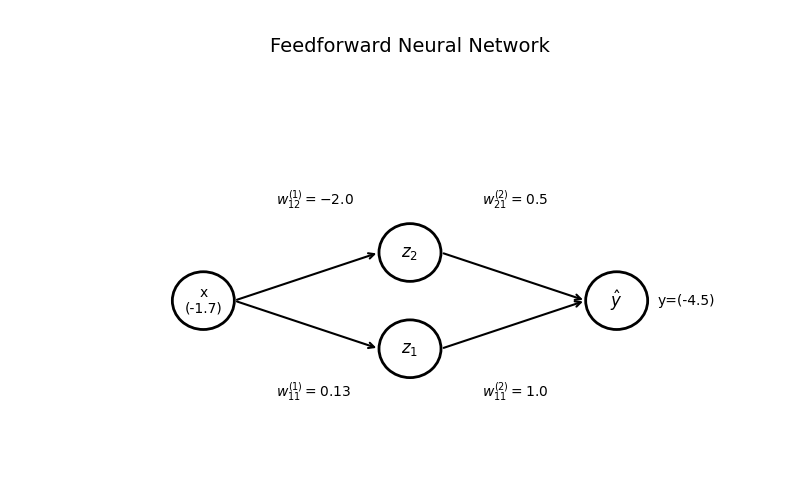

## Problem setup

Let's consider the following simplified network:
- **Input**: $x$, a single scalar input.
- **Hidden layer**: two neurons $z_1$ and $z_2$
- **Output**: $\hat{y}$

For a single input $x$, the hidden neurons are given by:

$$\begin{aligned}
\text{Neuron } z_1: & \quad a_1^{(1)} = w_{11}^{(1)} \cdot x, && \quad z_1 = g(a_1^{(1)}) = \frac{1}{1 + e^{-a_1^{(1)}}}, \\
\text{Neuron } z_2: & \quad a_2^{(1)} = w_{12}^{(1)} \cdot x, && \quad z_2 = g(a_2^{(1)}) = \frac{1}{1 + e^{-a_2^{(1)}}}.
\end{aligned}
$$

Then the output neuron combines these two hidden neurons:

$$\begin{aligned}
a_1^{(2)} &= w_{11}^{(2)} z_1 + w_{21}^{(2)} z_2, \\
\hat{y} &= g(a_1^{(2)}) = \frac{1}{1 + e^{-a_1^{(2)}}}.
\end{aligned}
$$

We consider a **loss** (squared error w.r.t. a true label $y$):

$$L = (y - \hat{y})^2.$$

Our goal is to **differentiate** $L$ with respect to the parameters:

$$\begin{aligned}
w_{11}^{(1)},\quad w_{12}^{(1)},\quad w_{11}^{(2)},\quad w_{21}^{(2)}.
\end{aligned}
$$

We will compute these derivatives in two ways:
1. **Symbolic Differentiation** (analytical formulas)
2. **Automatic Differentiation** (via PyTorch `backward()`)

We will show that these two results match.

## PyTorch implementation

### Define the activation function and its derivative 
We will use the logistic sigmoid $g(a) = 1 / (1 + e^{-a})$ as the activation function. Its derivative with respect to $a$ is:

$$\frac{d}{da} g(a) = g(a) \bigl(1 - g(a)\bigr).$$

However, for clarity, we can directly implement it as given in the example code:

In [21]:
def g(a):
    """
    Sigmoid function g(a) = 1 / (1 + e^-a)
    """
    return 1.0 / (1.0 + torch.exp(-a))

def gp(a):
    """
    Derivative of the sigmoid function g'(a)
    = exp(-a) / (1 + exp(-a))^2
    """
    return torch.exp(-a) / (1 + torch.exp(-a))**2

### Define the working variables
We will define:
- A target value $y$
- An input $x$
- Four weights we wish to learn/differentiate:
  - $w_{11}^{(1)}$ and $w_{12}^{(1)}$ for the hidden layer
  - $w_{11}^{(2)}$ and $w_{21}^{(2)}$ for the output layer

By setting `requires_grad=True`, PyTorch will keep track of operations involving these tensors, allowing automatic differentiation via the `backward()` call.

In [22]:
# Input
x = torch.tensor([-1.7])  # A single scalar input

# True target
y = torch.tensor([-4.5])  # A single scalar target

# Hidden layer weights
w11_1 = torch.tensor([0.13], requires_grad=True)  # w_{11}^{(1)}
w12_1 = torch.tensor([-2.0], requires_grad=True)  # w_{12}^{(1)}

# Output layer weights
w11_2 = torch.tensor([1.0], requires_grad=True)   # w_{11}^{(2)}
w21_2 = torch.tensor([0.5], requires_grad=True)   # w_{21}^{(2)}

### Forward pass
We compute:

$$a_1^{(1)} = w_{11}^{(1)} x,\quad
a_2^{(1)} = w_{12}^{(1)} x,\quad
z_1 = g(a_1^{(1)}),\quad z_2 = g(a_2^{(1)}),\quad
a_1^{(2)} = w_{11}^{(2)} z_1 + w_{21}^{(2)} z_2,\quad
\hat{y} = g(a_1^{(2)})
$$

and finally the loss $L = (y - \hat{y})^2$.

In [23]:
# Hidden neuron 1
a1_1 = w11_1 * x
z1   = g(a1_1)

# Hidden neuron 2
a2_1 = w12_1 * x
z2   = g(a2_1)

# Output neuron
a1_2 = w11_2 * z1 + w21_2 * z2
yhat = g(a1_2)

# Loss
L = (y - yhat)**2

### Symbolic gradients
From the slides and from our direct symbolic differentiation, we have:

$$\begin{aligned}
\frac{\partial L}{\partial w_{11}^{(1)}} 
&= -2 \,(y - \hat{y})\; g'(a_1^{(2)})\; w_{11}^{(2)}\; g'(a_1^{(1)})\; x,\\
\frac{\partial L}{\partial w_{12}^{(1)}} 
&= -2 \,(y - \hat{y})\; g'(a_1^{(2)})\; w_{21}^{(2)}\; g'(a_2^{(1)})\; x,\\
\frac{\partial L}{\partial w_{11}^{(2)}} 
&= -2 \,(y - \hat{y})\; g'(a_1^{(2)})\; z_1,\\
\frac{\partial L}{\partial w_{21}^{(2)}} 
&= -2 \,(y - \hat{y})\; g'(a_1^{(2)})\; z_2.
\end{aligned}$$

Let's compute these values explicitly in PyTorch (still using the same `gp` function for $g'(a)$).

In [24]:
# Symbolic gradients
Sgrad_L_w11_1 = -2 * (y - yhat) * gp(a1_2) * w11_2 * gp(a1_1) * x
Sgrad_L_w12_1 = -2 * (y - yhat) * gp(a1_2) * w21_2 * gp(a2_1) * x
Sgrad_L_w11_2 = -2 * (y - yhat) * gp(a1_2) * z1
Sgrad_L_w21_2 = -2 * (y - yhat) * gp(a1_2) * z2

Sgrad_L_w11_1, Sgrad_L_w12_1, Sgrad_L_w11_2, Sgrad_L_w21_2

(tensor([-0.8892], device='mps:0', grad_fn=<MulBackward0>),
 tensor([-0.0563], device='mps:0', grad_fn=<MulBackward0>),
 tensor([0.9424], device='mps:0', grad_fn=<MulBackward0>),
 tensor([2.0494], device='mps:0', grad_fn=<MulBackward0>))

### Automatic differentiation
We can then rely on PyTorch's **autograd** engine to compute the gradients for us. Simply call:

```python
L.backward()
```

and then retrieve the `.grad` attribute of each parameter of interest.

In [25]:
# Reset gradients (in case this cell is run multiple times)
w11_1.grad = None
w12_1.grad = None
w11_2.grad = None
w21_2.grad = None

# Perform backprop
L.backward()

# Automatic gradients
grad_L_w11_1 = w11_1.grad
grad_L_w12_1 = w12_1.grad
grad_L_w11_2 = w11_2.grad
grad_L_w21_2 = w21_2.grad

grad_L_w11_1, grad_L_w12_1, grad_L_w11_2, grad_L_w21_2

(tensor([-0.8892], device='mps:0'),
 tensor([-0.0563], device='mps:0'),
 tensor([0.9424], device='mps:0'),
 tensor([2.0494], device='mps:0'))

### Comparison of symbolic and automatic differentiation
Finally, let's print them side by side to verify they match (or are very close, up to floating-point rounding).

In [26]:
print("Loss L =", L.item())

print("\n--- dL/dw11^(2) ---")
print("Auto-grad:", grad_L_w11_2.item(), "\t Symbolic:", Sgrad_L_w11_2.item())

print("\n--- dL/dw21^(2) ---")
print("Auto-grad:", grad_L_w21_2.item(), "\t Symbolic:", Sgrad_L_w21_2.item())

print("\n--- dL/dw11^(1) ---")
print("Auto-grad:", grad_L_w11_1.item(), "\t Symbolic:", Sgrad_L_w11_1.item())

print("\n--- dL/dw12^(1) ---")
print("Auto-grad:", grad_L_w12_1.item(), "\t Symbolic:", Sgrad_L_w12_1.item())

Loss L = 27.21538734436035

--- dL/dw11^(2) ---
Auto-grad: 0.942385196685791 	 Symbolic: 0.9423852562904358

--- dL/dw21^(2) ---
Auto-grad: 2.049447774887085 	 Symbolic: 2.049448013305664

--- dL/dw11^(1) ---
Auto-grad: -0.8891823887825012 	 Symbolic: -0.8891823887825012

--- dL/dw12^(1) ---
Auto-grad: -0.05625968053936958 	 Symbolic: -0.05625968798995018


In this exercise, we demonstrated that for our simple 2-hidden-neuron feedforward network:

1. **Symbolic differentiation** (i.e., deriving the gradient expressions by hand)
2. **Automatic differentiation** (i.e., via PyTorch's `backward()`)

yield the **same** results, up to numerical precision. This is a powerful illustration of why automatic differentiation is so valuable: it **automates** what would otherwise be a lengthy (and error-prone) symbolic derivation process.

Feel free to change the values of $x$, $y$, and the weights $w$ to see how the gradients match up in other situations.
You can now expand this example to more complex network architectures or different activation and loss functions.

### Facial keypoints detection with PyTorch FCN and CNN architectures
Facial keypoint detection is the task of identifying important landmarks on a human face (e.g., corners of the eyes, nose tip, mouth corners) in an image. These keypoints are crucial for many applications in computer vision:

- Aligning faces for recognition or verification.
- Tracking facial expressions for emotion detection.
- Applying augmented reality filters or effects accurately on a face.

In this exercise, we will build fully connected neural networks and convolutional neural networks to detect **15 keypoints** on **96x96 grayscale face images**. The network will take an image as input and output the $ (x,y) $ coordinates of the **15 facial keypoints**.

Source: [danielnouri.org](https://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/)

### Dataset overview

We will use the **Kaggle Facial Keypoints Detection** dataset ([Kaggle challenge webpage](https://www.kaggle.com/competitions/facial-keypoints-detection)). This dataset consists of a training set of **7,049** face images (96x96 pixels, grayscale). Each image has up to **15 keypoint coordinates** labeled (30 values: $ x $ and $ y $ for each of 15 facial landmarks). For example, the keypoints include the centers of the eyes, the tip of the nose, and the corners of the mouth.

#### Data format
The training data is provided as a CSV file (`training.csv`). Each row contains:

- **30 columns** of keypoint coordinates: `left_eye_center_x`, `left_eye_center_y`, `right_eye_center_x`, ... etc. (15 keypoints $\times$ 2). If a keypoint was not labeled for a given image, its value is missing.
- An **Image** column containing 96x96 pixel intensity values (9216 numbers) in a single string, separated by spaces.

If you downloaded this exercise from the Université Virtuelle, you should have a `training.csv` file in the `data/` directory. Now, let's load the training data using pandas and examine its structure.

#### Missing values
Not all images have all 15 keypoints annotated. In fact, only about 30% of the images have all 15 keypoints; the rest have some missing keypoint labels. Nearly all images have at least a few keypoints (e.g., eyes, nose, mouth) labeled, but many did not have the more peripheral points. In this tutorial, for simplicity, we will use only images with **complete keypoint data** (all 15 points). This means we'll discard images with any missing keypoint values. (In practice, one could use data augmentation or multi-stage training to leverage partially labeled images, but we will not cover that here.)

In this exercise, you should:
1. Explore the dataset
2. Preprocess the dataset to use it with neural networks including:
      - handling missing values
      - converting the image data from strings to numeric arrays
      - normalizing the pixel values
      - reshaping the images
      - preparing the keypoint coordinates labels
3. Implement a fully connected neural network and compute the validated MSE
4. Implement a convolutional neural network and compute the validated MSE
5. Visualize the predictions of both models with respect to the true keypoints coordinates on images

In [27]:
import pandas as pd

# Load the training data
df = pd.read_csv('facial-keypoints-detection/training.csv')
print("Training data shape:", df.shape)
df.head(5)  # show first 5 rows as an example

Training data shape: (7049, 31)


,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


This will show the DataFrame with columns for each keypoint and the "Image" column containing pixel values. Let's check how many values are present in each column and how many are missing:

In [28]:
# Count non-null values in each column
print(df.count())

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

From this, we can see which keypoint columns have missing values. We expect some columns to have 7049 values (no missing data for those keypoints) and others to have fewer (indicating missing labels). If a column has fewer than 7049 non-null entries, the difference is the number of missing values.

## Data exploration

Before training a model, it's important to understand the dataset. We will:

1. Identify how many keypoint annotations are missing.
2. Visualize a few images with their annotated keypoints to get an intuition of the task.

### Missing Values
We already counted non-null values. Let's quantify missing data more directly:

In [29]:
# Check total missing values per column
missing_counts = df.isnull().sum()
print("Missing values per column:")
print(missing_counts)

Missing values per column:
left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_l

You should see that some keypoint columns (e.g., `left_eye_center_x`) have very few missing values, while others (e.g., some mouth or eyebrow points) have thousands of missing entries. In fact, only 2,140 images have **all** 15 keypoints labeled, meaning the remainder have some missing points. We will handle this in preprocessing by removing incomplete rows.

### Sample visualization
Let's visualize some of the images with their keypoints to understand the data. We will pick a few examples (ensuring they have no missing keypoints) and plot them in a grid.

Number of complete cases (no missing keypoints): 2140


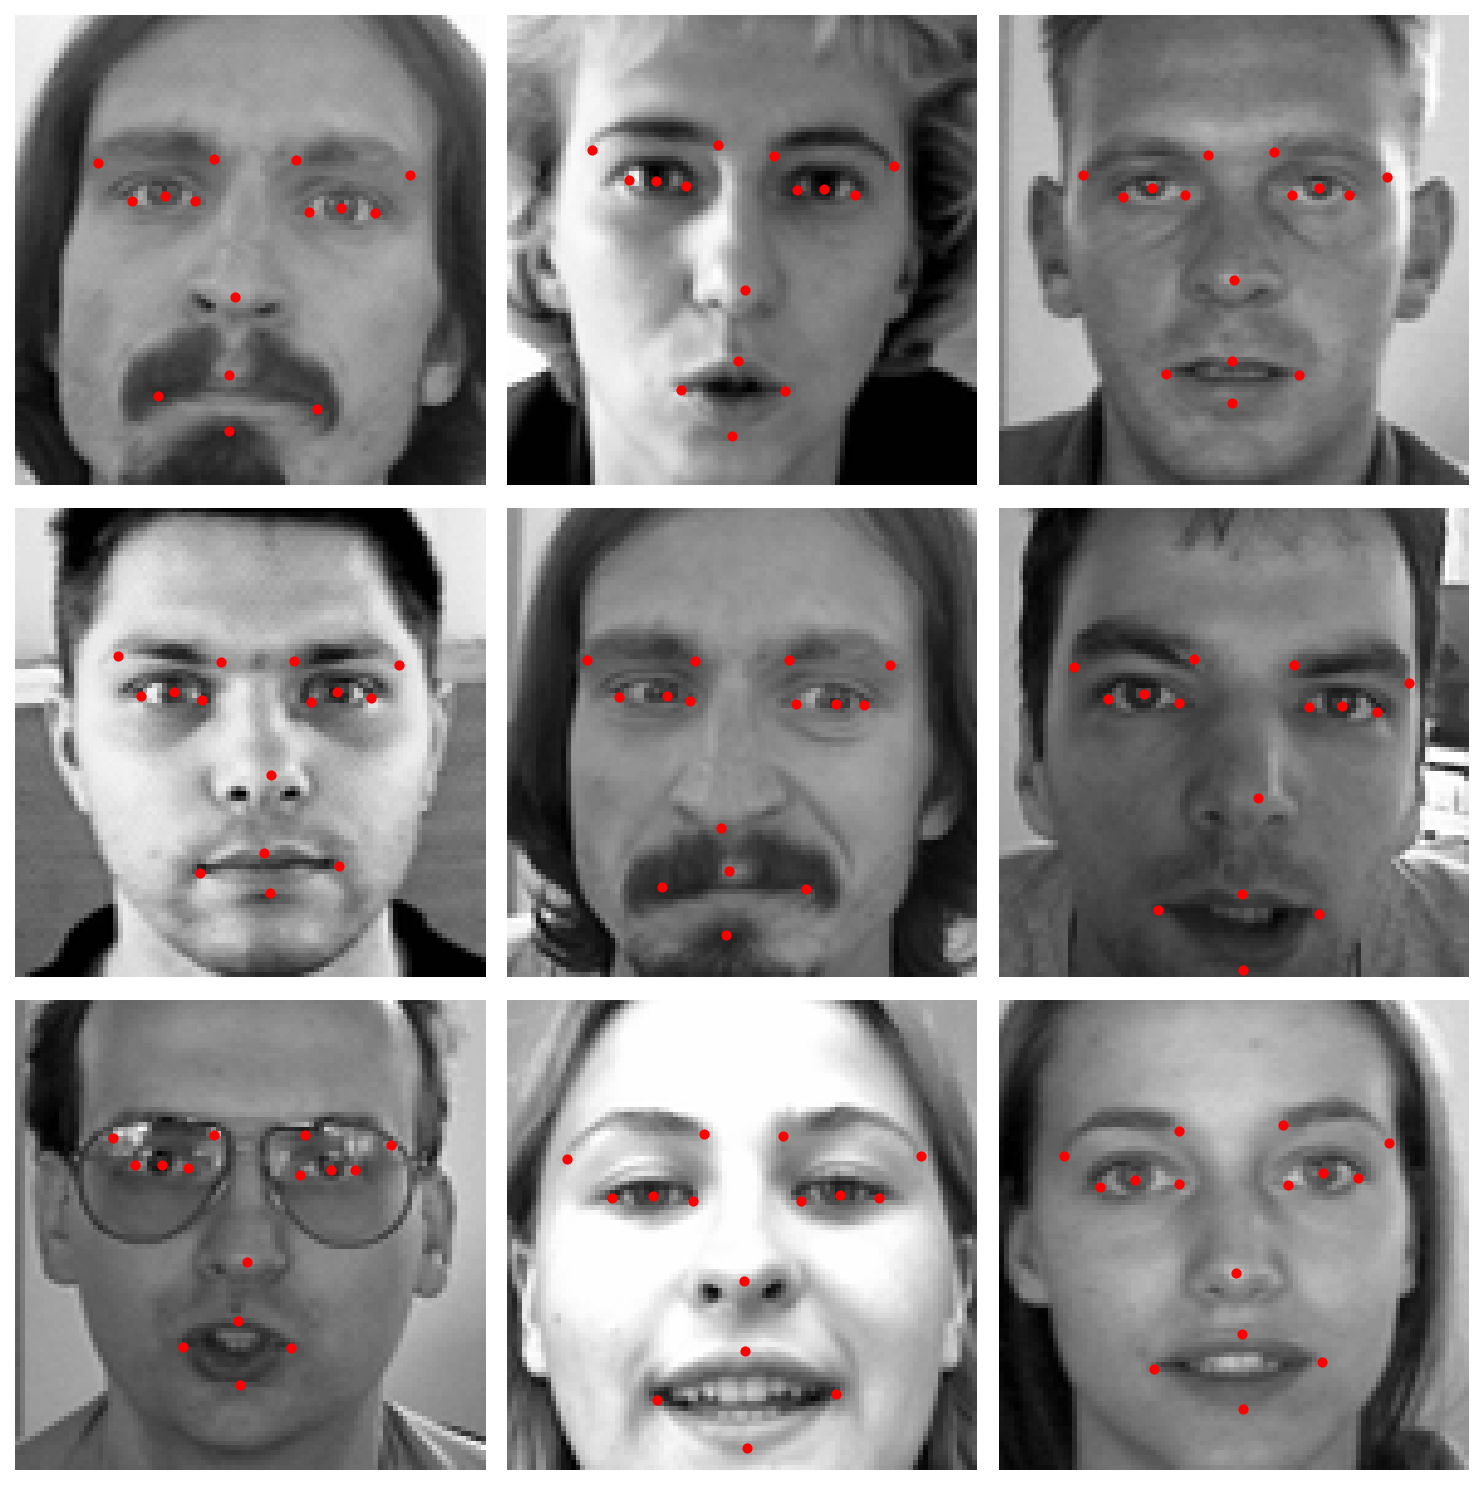

In [30]:
df_complete = df.dropna().reset_index(drop=True)
print("Number of complete cases (no missing keypoints):", len(df_complete))

sample_images = df_complete['Image'].iloc[:9].values
sample_images = [np.fromstring(img_str, sep=' ').reshape(96, 96) for img_str in sample_images]
sample_keypoints = df_complete.iloc[:9, :-1].values  # first 30 columns are keypoints

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()
for i in range(9):
    axes[i].imshow(sample_images[i], cmap='gray')
    # Plot keypoints as red dots
    kp = sample_keypoints[i]
    axes[i].scatter(kp[0::2], kp[1::2], c='red', s=15)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

We see 9 face images with red dots marking the locations of eyes, nose, mouth, etc. This visual check helps verify that the keypoints line up with facial features (for instance, dots around the eyes, nose, and mouth).

## Data preprocessing

Next, we need to prepare the data for training a PyTorch model. This involves:

1. **Handling missing keypoint values**: We'll simplify by using only the images that have all 15 keypoints labeled.
2. **Converting the image data** from strings to numeric arrays.
3. **Normalizing** the pixel values (scaling them to $[0,1]$) by dividing by 255.
4. **Reshaping** the images to the proper format ($ (N, 1, 96, 96) $ for a single-channel image).
5. **Preparing the keypoint coordinates** array of shape ($ N, 30 $). Each sample has 30 target values: 15 $ x $-coordinates and 15 $ y $-coordinates.

We encourage you to try at home to use more sophisticated data augmentation strategies or partial labeling approaches, but we'll keep things simple here.

In [31]:
# 1. Drop rows with missing values
df = df.dropna().reset_index(drop=True)
print("Remaining training samples after dropping missing:", len(df))

# 2. Convert the 'Image' column from strings to numpy arrays of shape (96,96)
df['Image'] = df['Image'].apply(lambda img: np.fromstring(img, sep=' ', dtype=np.float32))

# 3. Normalize pixel values to [0,1]
df['Image'] = df['Image'].apply(lambda img: img/255.0)

# 4. Convert list of image arrays to a 4D numpy array for model input
X_fcn = np.vstack(df['Image'].values)  # shape (N, 9216)
X_cnn = np.vstack(df['Image'].values).reshape(-1, 1, 96, 96).astype(np.float32)  # (N, 1, 96, 96)

# 5. Prepare keypoint targets as a numpy array
y = df[df.columns[:-1]].values  # all columns except the 'Image' column
y = y.astype(np.float32)
print("X_fcn shape:", X_fcn.shape, "y shape:", y.shape)
print("X_cnn shape:", X_cnn.shape, "y shape:", y.shape)

Remaining training samples after dropping missing: 2140


X_fcn shape: (2140, 9216) y shape: (2140, 30)
X_cnn shape: (2140, 1, 96, 96) y shape: (2140, 30)


## Fully connected neural network (FCN)

### FCN architecture

We create a **Fully Connected Neural Network (FCN)** using PyTorch to regress the 30 keypoint coordinates $(x, y)$ directly from flattened grayscale images (of size $96 \times 96 = 9216$ pixels). Feel free to adjust the hidden layer sizes and dropout probabilities based on your experimentation.<br>

The architecture of our FCN is as follows:

- **Fully Connected Layer 1:**  
  - Input: 9216 features (flattened image)  
  - Output: 1024 neurons  
  - Activation: ReLU  
  - Dropout: 0.3 probability (to reduce overfitting)

- **Fully Connected Layer 2:**  
  - Input: 1024 neurons  
  - Output: 512 neurons  
  - Activation: ReLU  
  - Dropout: 0.3 probability

- **Output Layer:**  
  - Input: 512 neurons  
  - Output: 30 neurons (coordinates for 15 keypoints)  
  - Linear activation (no final nonlinearity, since this is a regression output)

This FCN is trained using the **Mean Squared Error (MSE)** loss function to predict the $(x, y)$ coordinates of 15 facial keypoints from the flattened images.

In [32]:
class KeypointFCN(nn.Module):
    def __init__(self):
        super(KeypointFCN, self).__init__()
        # We have 96*96 = 9216 input features per image
        self.fc1 = nn.Linear(96*96, 1024)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(512, 30)  # 30 = (x,y) for 15 keypoints

    def forward(self, x):
        # x shape: (batch_size, 9216) 
        # (If x is not already flattened, do x = x.view(x.size(0), -1))
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

### Split the Flattened Dataset for Training/Validation

We already have $X_{fcn}$ of shape $(N, 9216)$ and $y$ of shape $(N, 30)$. We split them into training and validation sets:

In [33]:
from sklearn.model_selection import train_test_split

# 90/10 train-validation split using X_fcn
X_train_fcn, X_val_fcn, y_train_fcn, y_val_fcn = train_test_split(
    X_fcn, y, test_size=0.1, random_state=42
)

print("Training samples (FCN):", len(X_train_fcn), 
      "Validation samples (FCN):", len(X_val_fcn))

Training samples (FCN): 1926 Validation samples (FCN): 214


### Create PyTorch Datasets and DataLoaders

We'll create TensorDatasets from the NumPy arrays, then wrap them in DataLoaders for batching and shuffling. Notice that we **did not** reshape the input for the FCN version.

In [34]:
train_dataset_fcn = TensorDataset(
    torch.from_numpy(X_train_fcn).to(device),  # shape: (batch_size, 9216)
    torch.from_numpy(y_train_fcn).to(device)   # shape: (batch_size, 30)
)
val_dataset_fcn = TensorDataset(
    torch.from_numpy(X_val_fcn).to(device),
    torch.from_numpy(y_val_fcn).to(device)
)

g = torch.Generator(device=device)
train_loader_fcn = DataLoader(train_dataset_fcn, batch_size=64, shuffle=True, generator=g)
val_loader_fcn = DataLoader(val_dataset_fcn, batch_size=64, shuffle=False)

### Instantiate the FCN Model, define criterion and the optimizer

We use an MSE loss since we’re doing keypoint regression. We use the Adam optimiser in this exercise but you can experiment with any optimizer you like (Adam, SGD, etc.):

In [35]:
from torchsummary import summary
fcn_model = KeypointFCN().to(device)
summary(fcn_model.cpu(), X_train_fcn[0].shape)
fcn_model = fcn_model.to(device)
criterion_fcn = nn.MSELoss()  
optimizer_fcn = optim.Adam(fcn_model.parameters(), lr=0.001)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]       9,438,208
           Dropout-2                 [-1, 1024]               0
            Linear-3                  [-1, 512]         524,800
           Dropout-4                  [-1, 512]               0
            Linear-5                   [-1, 30]          15,390
Total params: 9,978,398
Trainable params: 9,978,398
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.02
Params size (MB): 38.06
Estimated Total Size (MB): 38.12
----------------------------------------------------------------


### Training with ongoing evaluation of the validation error

In [36]:
from tqdm.auto import tqdm
epochs = 20
for epoch in (pbar:=tqdm(range(1, epochs+1))):
    # --- Training ---
    fcn_model.train()
    train_loss = 0.0
    for batch_images, batch_keypoints in train_loader_fcn:
        outputs = fcn_model(batch_images)
        loss = criterion_fcn(outputs, batch_keypoints)

        optimizer_fcn.zero_grad()
        loss.backward()
        optimizer_fcn.step()

        train_loss += loss.item() * batch_images.size(0)
    train_loss /= len(train_loader_fcn.dataset)

    # --- Validation ---
    fcn_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_images, batch_keypoints in val_loader_fcn:
            preds = fcn_model(batch_images)
            loss = criterion_fcn(preds, batch_keypoints)
            val_loss += loss.item() * batch_images.size(0)
    val_loss /= len(val_loader_fcn.dataset)

    pbar.set_description(f"Epoch {epoch}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

### Evaluate on validation set

After the training completes, we can compute the validation set predictions and compute appropriate metrics to estimate the performance of the fully connected neural network model:

In [37]:
fcn_model.eval()
with torch.no_grad():
    val_preds_fcn = fcn_model(torch.Tensor(X_val_fcn).to(device)).cpu().numpy()
    
val_truth_fcn = y_val_fcn
mse_val_fcn = np.mean((val_preds_fcn - val_truth_fcn)**2)
rmse_val_fcn = np.sqrt(mse_val_fcn)

print(f"Validation RMSE (FCN): {rmse_val_fcn:.3f} pixels")

Validation RMSE (FCN): 9.839 pixels


## Convolutional neural network

We will create a Convolutional Neural Network (CNN) to **regress** the 30 keypoint coordinates from the input image. CNNs are highly effective in image analysis as they can automatically learn spatial hierarchies of features from images – from low-level edges to high-level shapes – which makes them well-suited for detecting patterns like facial features.<br> 

The architecture of our CNN will be as follows:

1. **Conv Layer 1**: 1 input channel (grayscale) -> 32 filters, kernel size 3x3, activation ReLU, followed by Max Pooling (2x2).
2. **Conv Layer 2**: 32 -> 64 filters, 3x3, ReLU, followed by Max Pooling (2x2).
3. **Conv Layer 3**: 64 -> 128 filters, 3x3, ReLU, followed by Max Pooling (2x2).
4. **Flatten**: Flatten the feature maps into a vector.
5. **Fully Connected 1**: 256 neurons, ReLU, with Dropout (to reduce overfitting).
6. **Fully Connected 2**: 128 neurons, ReLU, with Dropout.
7. **Output Layer**: 30 outputs (the $ x,y $ coordinates for 15 keypoints), linear activation (no final nonlinearity, since this is a regression output).

Dropout layers will help regularize the network by randomly dropping a fraction of neurons during training, which can improve generalization. We expect the CNN to learn to detect facial features through the convolutional layers (which capture local patterns like edges, corners of eyes/mouth, etc.), and the fully connected layers will combine these to predict the precise coordinates.

In [38]:
class KeypointCNN(nn.Module):
    def __init__(self):
        super(KeypointCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)   # 96x96 -> 94x94 (then 47x47 after pool)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)  # 47x47 -> 45x45 (then 22x22 after pool)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3) # 22x22 -> 20x20 (then 10x10 after pool)
        self.pool = nn.MaxPool2d(2, 2)

        # Dropout layers
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 10 * 10, 256)  # 128 feature maps * 10 * 10
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 30)  # 30 outputs (x,y for 15 keypoints)
        
    def forward(self, x):
        # Three conv layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers with dropout and ReLU
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

## Training the model

Now, let's train the model on our training data and monitor its performance on the validation set.

- **Data Loaders**: We'll use PyTorch `DataLoader` to batch and shuffle the data for training and to batch the validation data.
- **Loss Function**: This is a regression problem (predicting continuous coordinate values), so a common choice is **Mean Squared Error** (`nn.MSELoss`) in PyTorch.
- **Optimizer**: We'll use **Adam** for efficient stochastic gradient descent.
- **Training Loop**: We'll train for a number of epochs (iterations over the whole training set). In each epoch:
  1. Set the model to training mode.
  2. Loop over mini-batches from the training loader.
  3. For each batch, do a forward pass to get predictions, compute the loss, do a backward pass to compute gradients, and update weights.
  4. Evaluate the model on the validation set after each epoch to track performance.


In [39]:
from sklearn.model_selection import train_test_split

# We'll do a 90/10 train-validation split
X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_cnn, y, test_size=0.1, random_state=42)
print("Training samples:", len(X_train_cnn), "Validation samples:", len(X_val_cnn))

Training samples: 1926 Validation samples: 214


In [40]:
# Create TensorDatasets for train and validation
train_dataset = TensorDataset(torch.from_numpy(X_train_cnn).to(device), torch.from_numpy(y_train_cnn).to(device))
val_dataset = TensorDataset(torch.from_numpy(X_val_cnn).to(device), torch.from_numpy(y_val_cnn).to(device))

# DataLoader for batching
g = torch.Generator(device=device)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, generator=g)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [41]:
cnn_model = KeypointCNN()
summary(cnn_model.cpu(), X_train_cnn[0].shape)
cnn_model = cnn_model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 94, 94]             320
         MaxPool2d-2           [-1, 32, 47, 47]               0
            Conv2d-3           [-1, 64, 45, 45]          18,496
         MaxPool2d-4           [-1, 64, 22, 22]               0
            Conv2d-5          [-1, 128, 20, 20]          73,856
         MaxPool2d-6          [-1, 128, 10, 10]               0
            Linear-7                  [-1, 256]       3,277,056
           Dropout-8                  [-1, 256]               0
            Linear-9                  [-1, 128]          32,896
          Dropout-10                  [-1, 128]               0
           Linear-11                   [-1, 30]           3,870
Total params: 3,406,494
Trainable params: 3,406,494
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forw

In [42]:
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

epochs = 20
for epoch in (pbar:=tqdm(range(1, epochs+1))):
    cnn_model.train()
    train_loss = 0.0
    for batch_images, batch_keypoints in train_loader:
        images = batch_images
        keypoints = batch_keypoints

        outputs = cnn_model(images)
        loss = criterion(outputs, keypoints)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
    train_loss /= len(train_loader.dataset)

    # Validation phase
    cnn_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_images, batch_keypoints in val_loader:
            images = batch_images
            keypoints = batch_keypoints
            preds = cnn_model(images)
            loss = criterion(preds, keypoints)
            val_loss += loss.item() * images.size(0)
    val_loss /= len(val_loader.dataset)

    pbar.set_description(f"Epoch {epoch}/{epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

## Evaluation and results

After training, we'll evaluate the model's performance. One common metric for this task is **Root Mean Squared Error (RMSE)** of the keypoint predictions. RMSE is the square root of MSE, giving an error in the same units as the coordinates (pixels). We will calculate RMSE on the validation set.

For instance, an RMSE of 4.0 would mean on average the predictions are about 4 pixels away from the true keypoint positions.

In [43]:
# Switch to evaluation mode
cnn_model.eval()

# Predict on the entire validation set
with torch.no_grad():
    val_preds = cnn_model(torch.Tensor(X_val_cnn).to(device)).cpu().numpy()

# Compute RMSE on validation set
val_truth = y_val_cnn  # actual keypoints
mse_val = np.mean((val_preds - val_truth)**2)
rmse_val = np.sqrt(mse_val)
print(f"Validation RMSE: {rmse_val:.3f} pixels")

Validation RMSE: 3.312 pixels


### Visualizing predictions
Finally, let's visualize some predictions to see how the model is performing. We'll take a few images from the validation set (which the model hasn't seen during training) and plot the image with:

- The **ground truth** keypoints (in green)
- The **predicted** keypoints (in red)

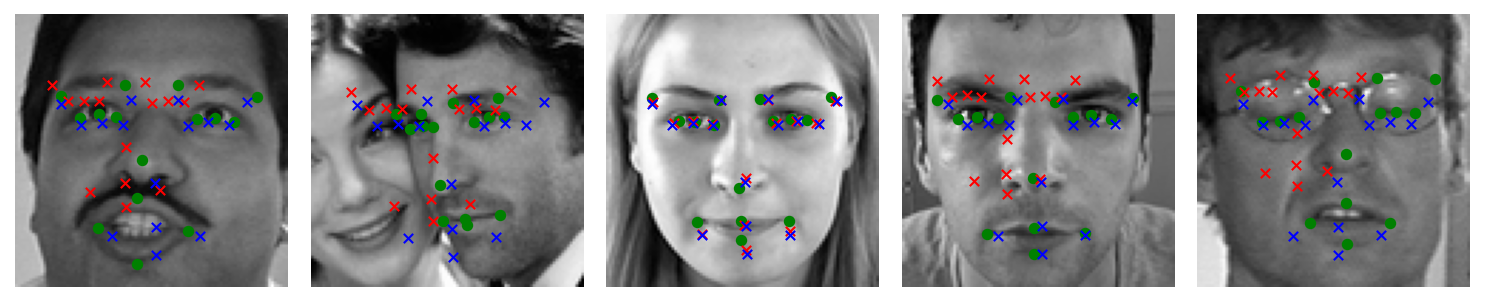

In [44]:
# Choose a few samples from validation to visualize
num_samples_to_show = 5
indices = np.random.choice(len(X_val), size=num_samples_to_show, replace=False)

fig, axes = plt.subplots(1, num_samples_to_show, figsize=(10, 6))
for i, idx in enumerate(indices):
    img = X_val_fcn[idx].reshape(96, 96)
    true_kp = y_val_fcn[idx]
    cnn_pred_kp = val_preds[idx]
    fcn_pred_kp = fcn_model(torch.tensor(X_val_fcn[idx].reshape(1, 96*96)).to(device)).cpu().detach().numpy()[0]

    axes[i].imshow(img, cmap='gray')
    # Plot true keypoints in green
    axes[i].scatter(true_kp[0::2], true_kp[1::2], c='green', s=20, label='True')
    # Plot predicted keypoints in red
    axes[i].scatter(fcn_pred_kp[0::2], fcn_pred_kp[1::2], c='red', s=20, marker='x', label='Pred')
    # Plot predicted keypoints in red
    axes[i].scatter(cnn_pred_kp[0::2], cnn_pred_kp[1::2], c='blue', s=20, marker='x', label='Pred')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In the displayed images, **green** dots should mark the actual keypoint positions and **red** x's mark the model's predicted positions. Ideally, they will be close for most points. You might notice the model does well on prominent features like the eye centers or nose tip, but could be less accurate on some others, especially if the network hasn't fully converged or if data is limited. A deeper network or additional data augmentation could further improve performance.